<a href="https://colab.research.google.com/github/devt287/applied_stat/blob/main/HW6_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
theta_0 = 0.5  # true location parameter
n_set = c(20,50,100,200,500,1000)  # set of sample sizes in the experiment
mc_times = 20  # number of Monte Carlo simulations

In [2]:
# the necessary R package for generating Laplace distributed random variables
install.packages("VGAM")
library("VGAM")

generate_laplace <- function(n, theta_0){
  # generate n iid Laplace random variables with mean theta_0 and variance 1
  sample = rlaplace(n, location = theta_0, scale = 1)
  sample = pmin(pmax(sample,-5),5) # thresholding to avoid numeric issues
  return(sample)
}

Warning message:
“unable to access index for repository https://cran.r-project.org/src/contrib:
  cannot open URL 'https://cran.r-project.org/src/contrib/PACKAGES'”
Warning message:
“package ‘VGAM’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message:
“unable to access index for repository https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3:
  cannot open URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3/PACKAGES'”
Loading required package: stats4

Loading required package: splines



In [3]:
# this function estimates the density f(x) based on the sample
# bw is the bandwidth parameter used in the computation
density_est <- function(x, sample, bw) {
  x = x + median(sample)
  return( mean(dnorm(x - sample, sd = sqrt(bw))) )
}

# this function estimates the density derivative f'(x) based on the sample
# bw is the bandwidth parameter used in the computation
density_deriv_est <- function(x, sample, bw) {
  x = x + median(sample)
  return( mean(-((x-sample)/(bw^2)) * dnorm(x - sample, sd = sqrt(bw))))
}

# this function outputs the semiparametric estimate of theta_0
semiparametric_estimate <- function(sample){
  bw = density(sample)$bw # set the bandwidth parameter
  stein_equation <- function(theta) {
    # Shift the sample by the estimate of theta_0
    shifted_sample <- sample - theta
    # Calculate the estimated density and its derivative at the shifted sample
    f_hat <- density_est(shifted_sample, sample, bw)
    f_prime_hat <- density_deriv_est(shifted_sample, sample, bw)
    # Compute the left-hand side of Stein's equation
    lhs <- mean(shifted_sample * f_hat)
    # Compute the right-hand side of Stein's equation
    rhs <- mean(f_prime_hat)
    # Return the difference (should be zero at the solution)
    lhs + rhs
  }
  
  # Use uniroot to solve for theta_0
  root <- uniroot(stein_equation, interval = c(-10, 10))
  
  return(root$root)

  # YOUR CODE (5-10 lines):
  # based on the estimates of the density and derivative, use Stein's estimating
  # equation to compute the semiparametric estimate of theta_0
  #
  # Note: the "uniroot" function finding the zero of a 1D function might be useful:
  # https://stat.ethz.ch/R-manual/R-devel/library/stats/html/uniroot.html
  # In uniroot, you may set interval = c(-10, 10)

}

Warning message:
“unable to access index for repository https://cran.r-project.org/src/contrib:
  cannot open URL 'https://cran.r-project.org/src/contrib/PACKAGES'”
Warning message:
“package ‘reshape2’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message:
“unable to access index for repository https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3:
  cannot open URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.3/PACKAGES'”


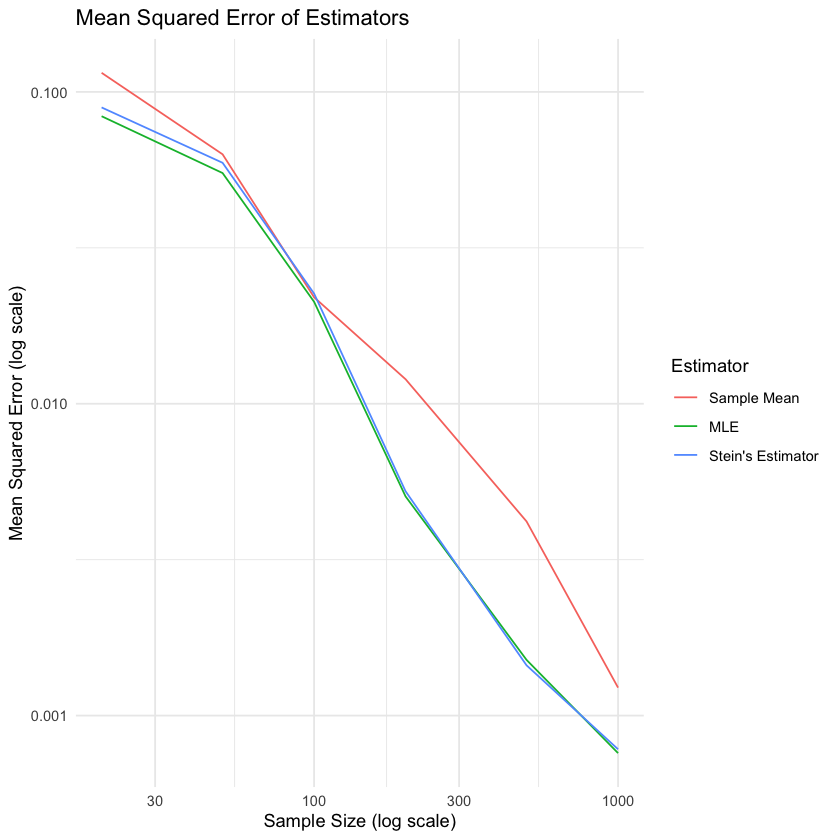

In [4]:
library("ggplot2")
set.seed("2023")
install.packages("reshape2")


# YOUR CODE (~20 lines):
# 1. for each value n in n_set, generate a sample of size n with truth theta_0
# 2. compute three estimators based on the sample:
### 2.1. the sample average;
### 2.2. the MLE with known f (you are supposed to derive the MLE in this case
### by hand, which should be a very simple function of the sample)
### 2.3. Stein's semiparametric estimator.
# 3. repeat the above procedure for mc_times=20 times, and output the mean
# squared error for each (n, estimator) pair (so 6*3 matrix in total)
# 4. use ggplot, draw (mean squared error ~ n) in a line chart with log-log scale;
# all three curves for different estimators should be in te same plot
# Note: the overall runtime might take several minutes, so it is advised to
# start from small-scale experiments
# Assuming you have defined the functions: generate_laplace, density_est, density_deriv_est, and semiparametric_estimate

# Pre-allocate matrix to store the results
# Initialize a matrix to store MSE for each estimator
mse_matrix <- matrix(0, nrow = length(n_set), ncol = 3)
rownames(mse_matrix) <- n_set
colnames(mse_matrix) <- c("Sample Mean", "MLE", "Stein's Estimator")

# Monte Carlo simulation
for (n in n_set) {
  mse_values <- matrix(0, nrow = mc_times, ncol = 3)
  
  for (mc in 1:mc_times) {
    # Generate sample
    sample <- generate_laplace(n, theta_0)
    
    # Compute estimators
    sample_mean <- mean(sample)
    mle_estimate <- median(sample)  # MLE for Laplace distribution is the median
    stein_estimate <- semiparametric_estimate(sample)
    
    # Compute squared errors
    mse_values[mc, ] <- c((sample_mean - theta_0)^2, (mle_estimate - theta_0)^2, (stein_estimate - theta_0)^2)
  }
  
  # Compute the mean squared error for each estimator
  mse_matrix[as.character(n), ] <- colMeans(mse_values)
}

# Reshape for ggplot
mse_df <- as.data.frame(mse_matrix)
mse_df$n <- rownames(mse_matrix)
mse_df_long <- reshape2::melt(mse_df, id.vars = 'n', variable.name = 'Estimator', value.name = 'MSE')
mse_df_long$n <- as.numeric(mse_df_long$n)

# Plotting
ggplot(mse_df_long, aes(x = n, y = MSE, color = Estimator)) +
  geom_line() +
  scale_x_log10() +
  scale_y_log10() +
  labs(title = "Mean Squared Error of Estimators",
       x = "Sample Size (log scale)",
       y = "Mean Squared Error (log scale)",
       color = "Estimator") +
  theme_minimal()

